In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [39]:
train_DT = datasets.CIFAR10(root='./dataset', train=True, download=True)
test_DT = datasets.CIFAR10(root='./dataset', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
class CustomDataset(Dataset):
    def __init__(self, CIFAR10_Dataset, transform):
        self.data = CIFAR10_Dataset.data
        self.label = torch.tensor(CIFAR10_Dataset.targets)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.transform(self.data[index]), self.label[index]
    
train_dataset, val_dataset = random_split(CustomDataset(train_DT, transforms.ToTensor()), (40000, 10000))
test_dataset = CustomDataset(test_DT, transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last=True)

In [37]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.MaxPool1 = nn.MaxPool2d(2, 2)

        self.conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.MaxPool2 = nn.MaxPool2d(2, 2)

        self.conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.MaxPool3 = nn.MaxPool2d(2, 2)

        self.fc = nn.Sequential(
            nn.Linear(4096, 64),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.MaxPool1(self.conv1(x))
        x = self.MaxPool2(self.conv2(x))
        x = self.MaxPool3(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

train_loss_history = []
val_loss_history = []

for epoch in range(10):
    model.train()
    train_loss = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        pred_y = model(x)
        loss = criterion(pred_y, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
    
    train_loss = train_loss / len(train_dataloader)
    train_loss_history.append(float(train_loss.detach().cpu()))

    with torch.no_grad():
        model.eval()
        val_loss = 0.0

        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)

            pred_y = model(x)
            loss = criterion(pred_y, y)

            val_loss += loss
        
        val_loss = val_loss / len(val_dataloader)
        val_loss_history.append(float(val_loss.detach().cpu()))

    print(f'Epoch:{epoch:2}    Train_Loss:{round(float(train_loss), 3):5}    Val_Loss:{round(float(val_loss), 3):5}')

Epoch: 0    Train_Loss:1.297    Val_Loss:1.109
Epoch: 1    Train_Loss: 0.92    Val_Loss:0.914
Epoch: 2    Train_Loss:0.785    Val_Loss:0.883
Epoch: 3    Train_Loss:0.679    Val_Loss:0.926
Epoch: 4    Train_Loss:0.591    Val_Loss:0.872
Epoch: 5    Train_Loss:0.514    Val_Loss:0.797
Epoch: 6    Train_Loss:0.439    Val_Loss:0.833
Epoch: 7    Train_Loss:0.374    Val_Loss:0.799
Epoch: 8    Train_Loss:0.308    Val_Loss:0.805
Epoch: 9    Train_Loss:0.253    Val_Loss:0.824


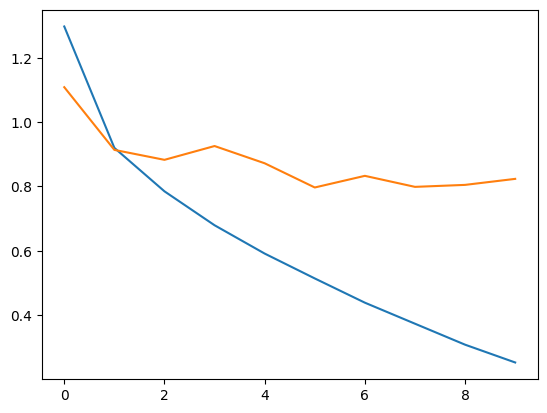

In [40]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [41]:
correct = 0
wrong = 0

with torch.no_grad():
    model.eval()

    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        pred_y = model(x)
        pred_label = torch.argmax(pred_y, dim=1)

        for idx in range(len(y)):
            if y[idx] == pred_label[idx]:
                correct += 1
            else:
                wrong += 1

print(f'Correct  : {correct}')
print(f'Wrong    : {wrong}')
print(f'Accuracy : {round((correct)/(correct+wrong)*100, 2)}%')

Correct  : 7427
Wrong    : 2557
Accuracy : 74.39%


### Feature Map 확인

torch.Size([3, 32, 32])


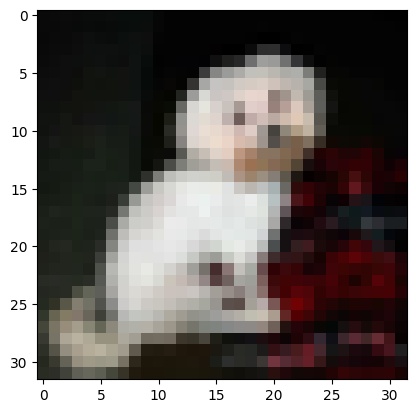

In [84]:
with torch.no_grad():
    model.eval()

    x, y = next(iter(train_dataloader))
    x = x.to(device)
    y = y.to(device)

    pred_y = model(x)
    pred_label = torch.argmax(pred_y, dim=1)

    feature_map_1 = model.conv1(x)
    feature_map_2 = model.conv2(model.MaxPool1(feature_map_1))
    feature_map_3 = model.conv3(model.MaxPool2(feature_map_2))

x = x.cpu()
feature_map_1 = feature_map_1.cpu()
feature_map_2 = feature_map_2.cpu()
feature_map_3 = feature_map_3.cpu()

print(x[0].shape)
plt.imshow(x[0].cpu().permute(1, 2, 0))

torch.Size([64, 64, 32, 32])


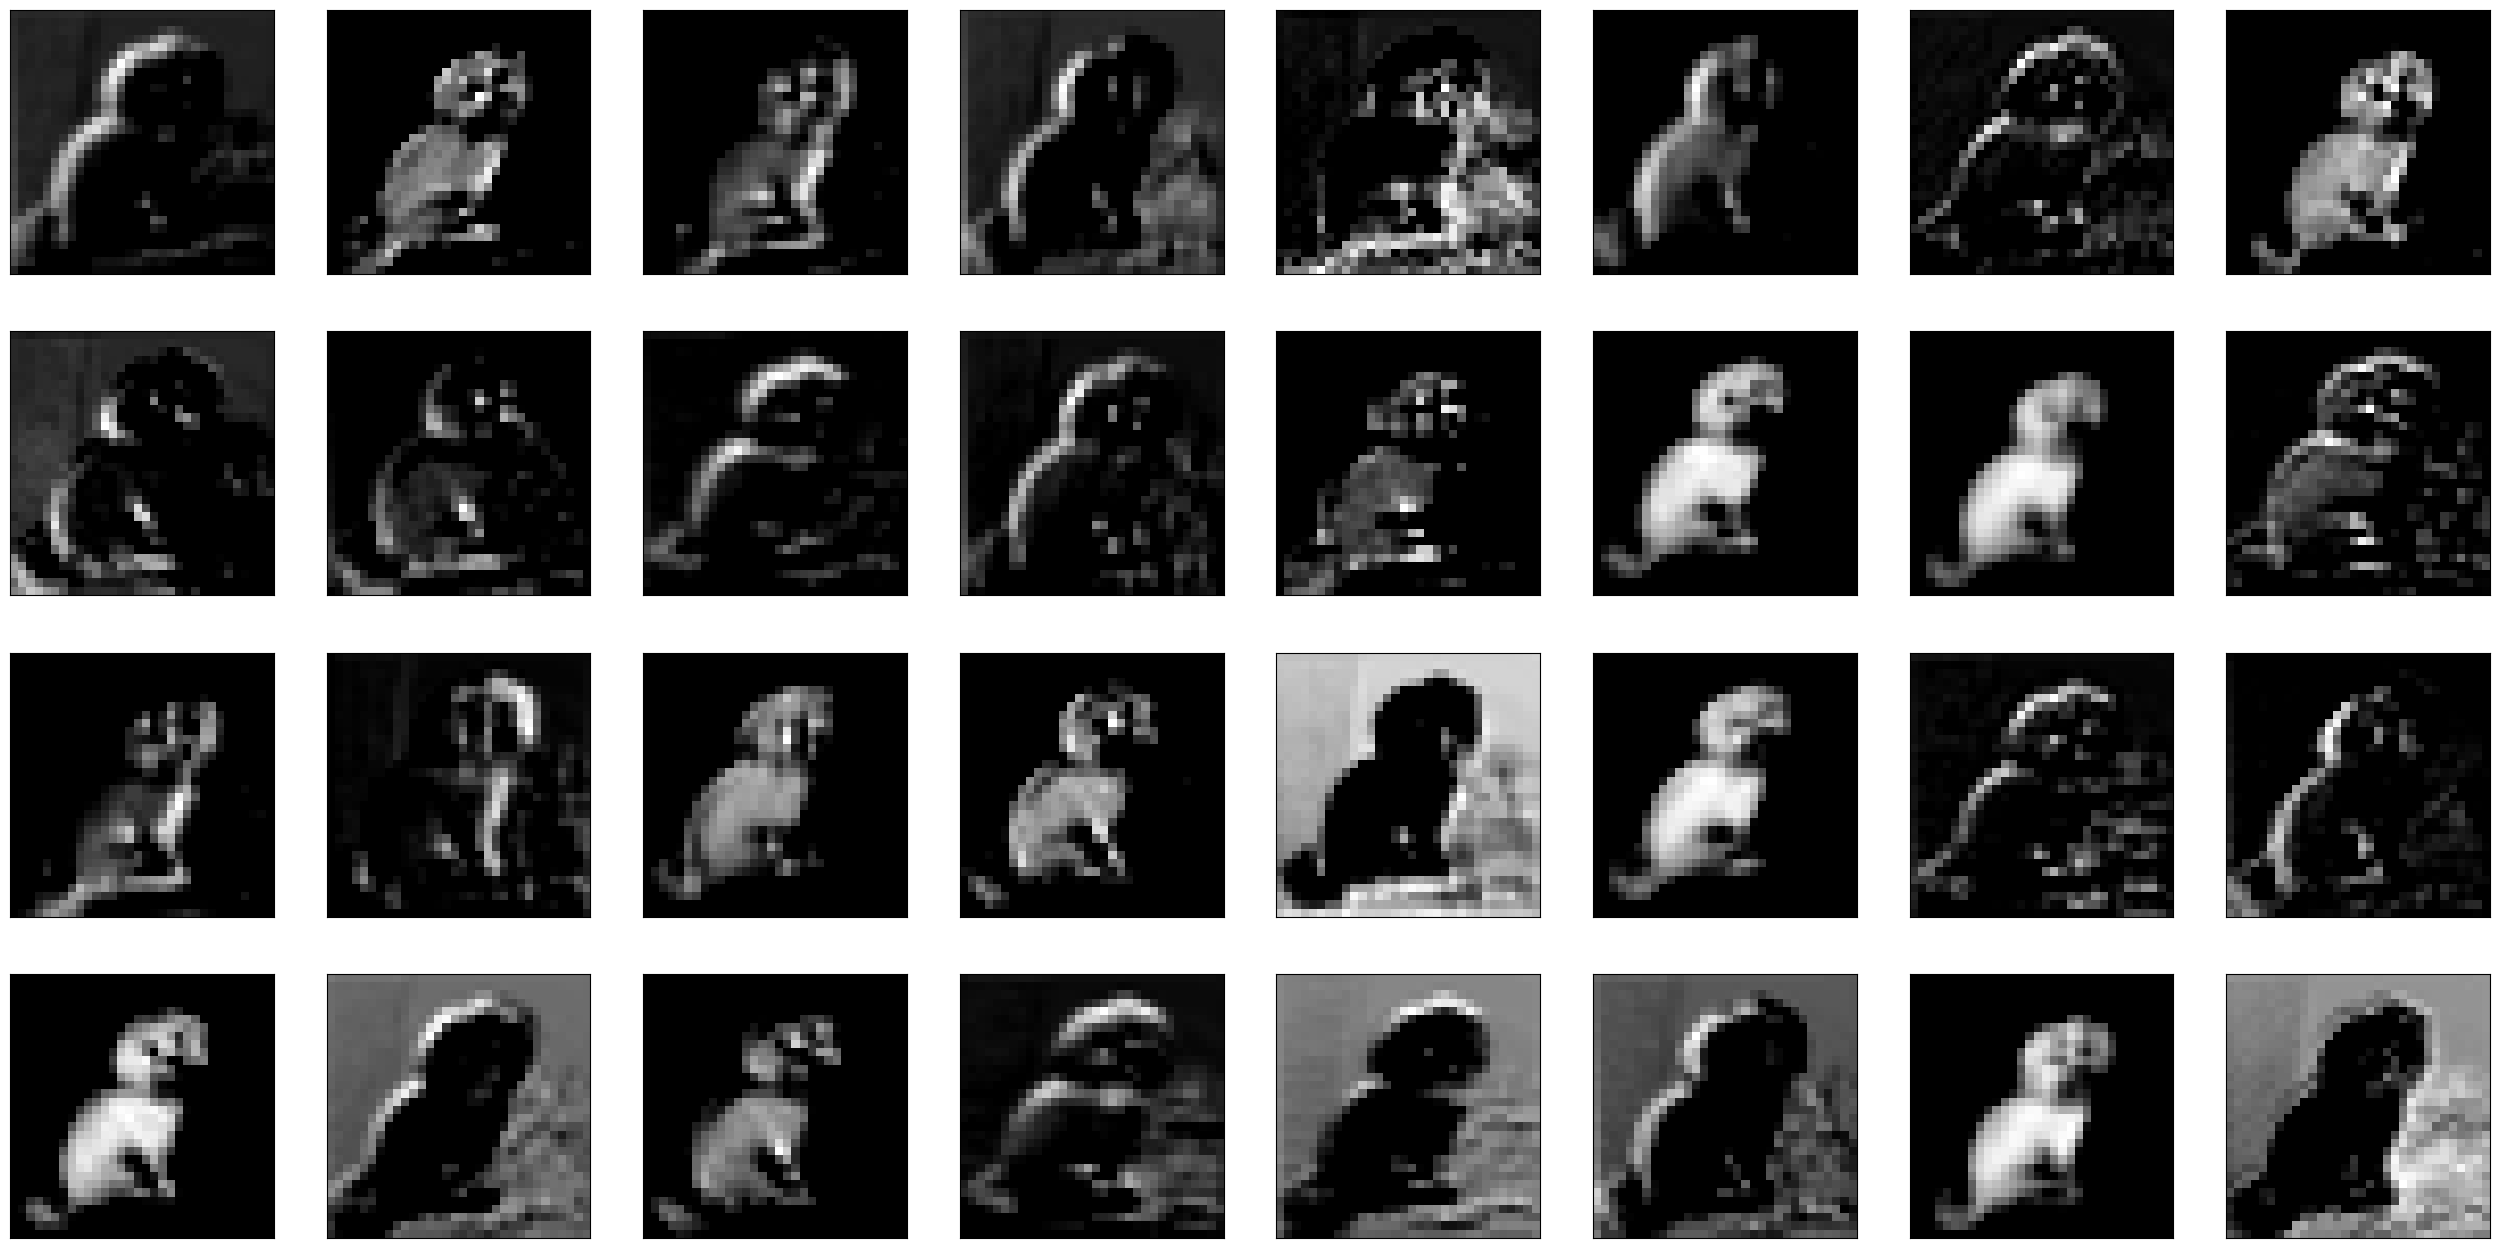

In [85]:
print(feature_map_1.shape)
plt.figure(figsize=(32,16))
for idx in range(32):
    plt.subplot(4,8,idx+1, xticks=[], yticks=[])
    plt.imshow(feature_map_1[0,idx,...], cmap="gray")

torch.Size([64, 128, 16, 16])


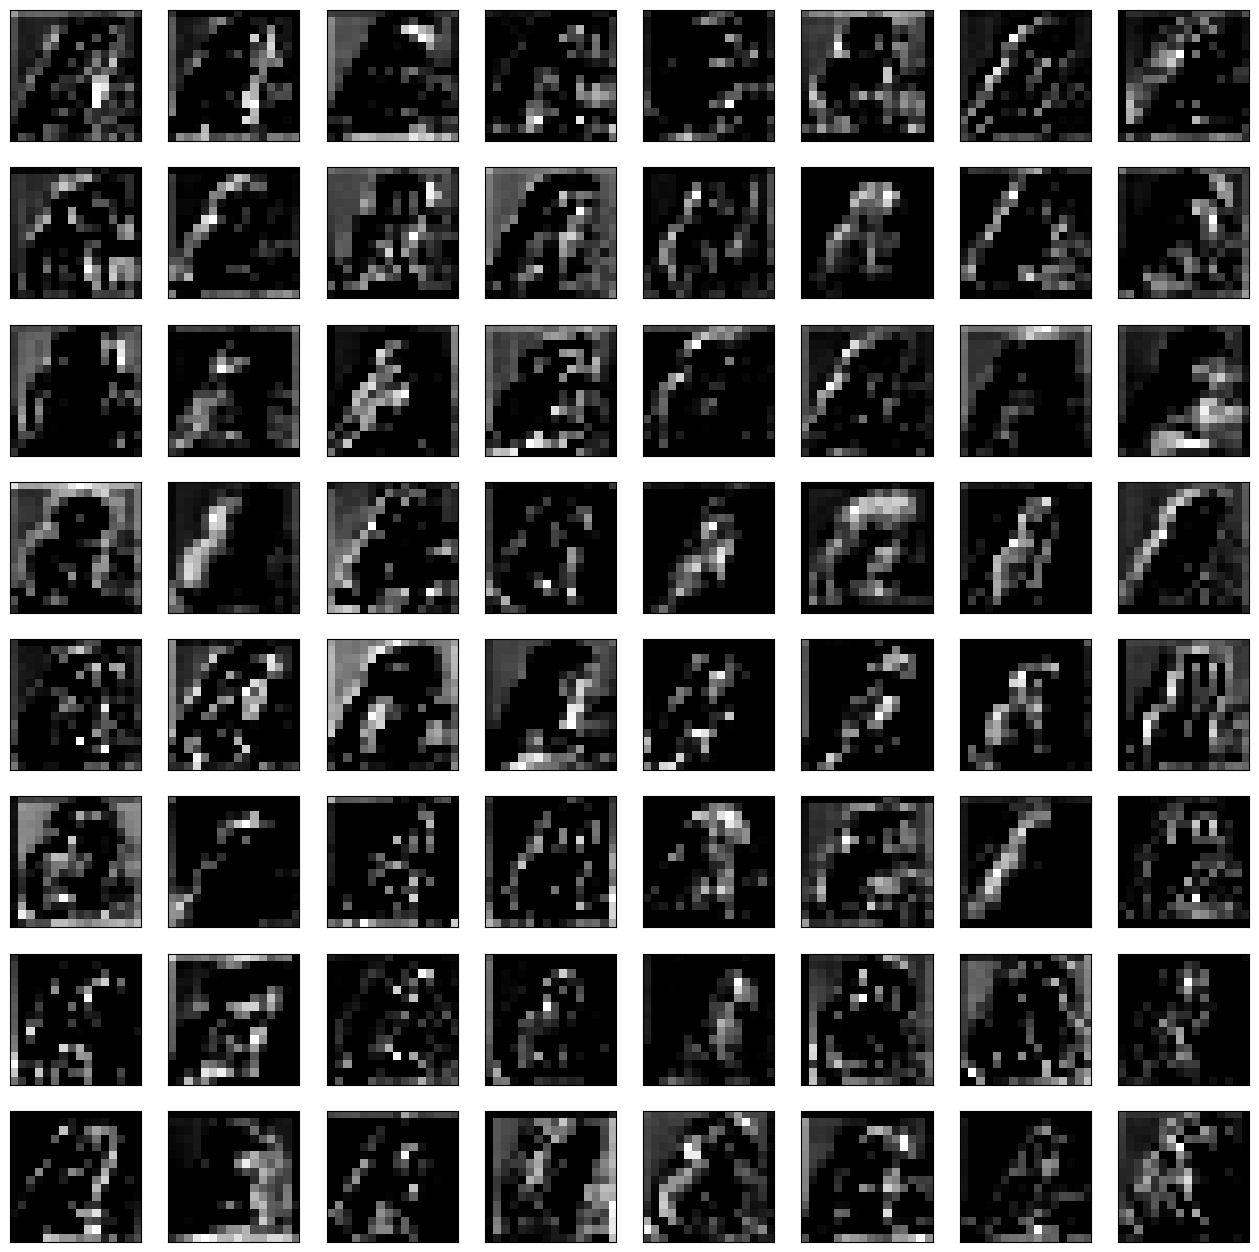

In [86]:
print(feature_map_2.shape)
plt.figure(figsize=(16,16))
for idx in range(64):
    plt.subplot(8,8,idx+1, xticks=[], yticks=[])
    plt.imshow(feature_map_2[0,idx,...], cmap="gray")

torch.Size([64, 256, 8, 8])


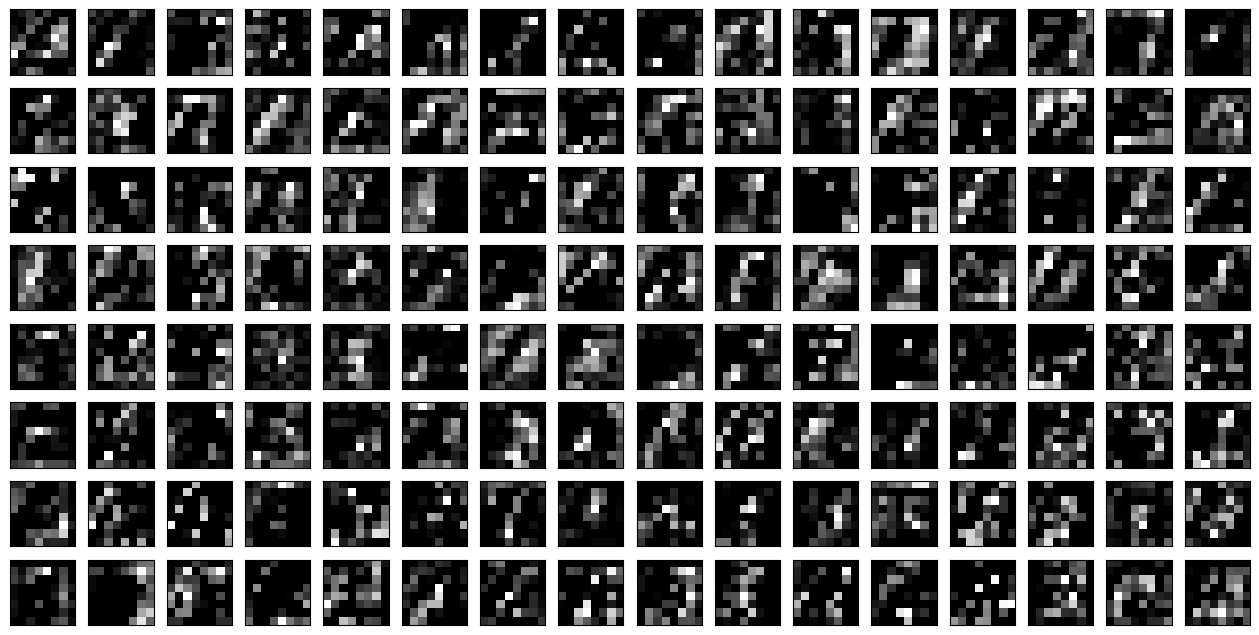

In [87]:
print(feature_map_3.shape)
plt.figure(figsize=(16, 8))
for idx in range(128):
    plt.subplot(8, 16, idx+1, xticks=[], yticks=[])
    plt.imshow(feature_map_3[0,idx,...], cmap="gray")


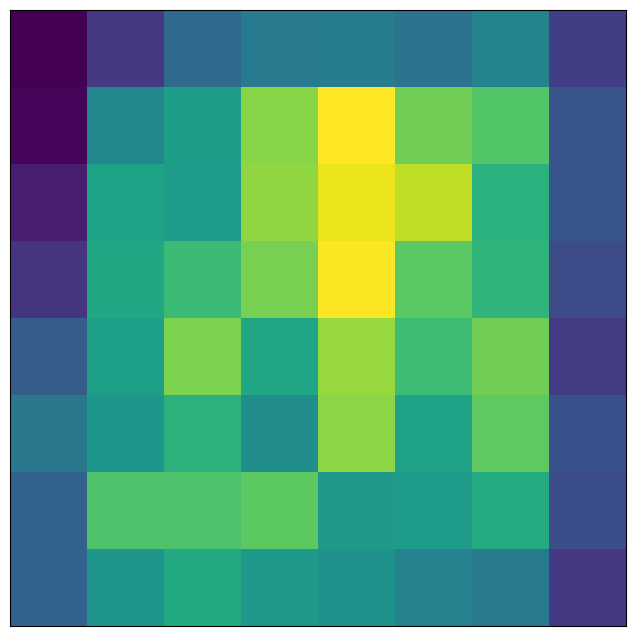

In [88]:
summed_map = feature_map_3.abs().sum(dim=1)

plt.figure(figsize=(8, 8))
plt.xticks([]); plt.yticks([])
plt.imshow(summed_map[0,...])

Text(0.5, 1.0, 'dog (dog)')

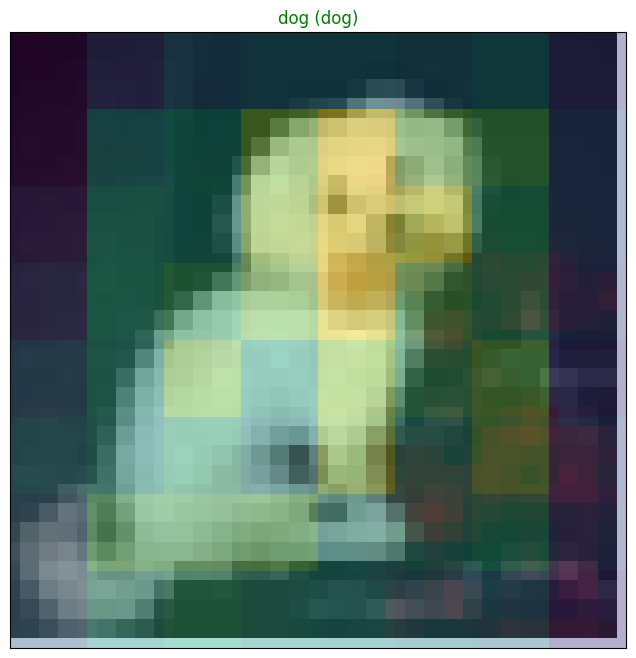

In [89]:
plt.figure(figsize=(8, 8))
plt.xticks([]); plt.yticks([])
plt.imshow(x[0,...].permute(1, 2, 0))
plt.imshow(summed_map[0,...], extent=[0,32,32,0], alpha=0.4)

pred_class = test_DT.classes[int(pred_label[0])]
true_class = test_DT.classes[int(y[0])]
plt.title(f"{pred_class} ({true_class})", color="g" if pred_class==true_class else "r")